
There are 2 stages to this experiment. First is to bucket the dataset and second is to train based on entropy score. 
Bucketing the dataset involves the following:
1. using ``google-bert/bert-base-uncased``, we will tokenize the text.
2. On default, ``bert-base-uncased`` creates embeddings that are in 768 dimensions.
3. Embeddings are then reduced in size to around 50.
4. Extract n amount from each bucket to create the first training stage dataset.

Training based on entropy score involves the following:
1. Remove the previously trained data from the dataset pool.
2. Predict on the rest of the dataset pool using the previously trained data in stage 1.
3. Convert prediction scores to entropy
4. Sort by highest entropy, seperate into buckets again.
5. Extract m amount from each bucket to create the second training stage dataset.
  
Entropy based training can be done multiple times until sufficient.

For each stage, we can compare it to a model trained on a randomly selected amount of data from the dataset pool. 

Since we are trying to prove that it is possible to create a high quality model without a huge amount of data, for each comparison, we can select the same amount of data used to train the bucketing model up to that point.

# Load and preprocess dataset
We are trying to prove that bucketing and entropy based training can reduce the amount of data needed to reduce a well balanced model. This is a case of one-shot model training. To reduce external factors such as bad data quality, etc; we will be utilizing StanfordNLP's SST2 dataset which  is a standard NLP benchmark for sentiment classification. The dataset will be loaded from huggingface via ``stanfordnlp/sst2``

In [6]:
from datasets import load_dataset
ds = load_dataset("mteb/amazon_polarity", cache_dir="caches/")

Let's split into 3 variables

In [7]:
train_ds = ds["train"]
test_ds = ds["test"]

In [8]:
train_ds

Dataset({
    features: ['label', 'text', 'label_text'],
    num_rows: 3599994
})

Perform very light cleaning on the dataset

In [9]:
import re
def clean_text(row):
    text = row["text"]
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove non-printable characters
    text = re.sub(r"[\x00-\x1F\x7F]", " ", text)
    # Replace multiple spaces/newlines with single space
    text = re.sub(r"\s+", " ", text)
    # Optionally lowercase
    text = text.strip()  # Don't lowercase if case matters
    return {
        "text": text
    }

4 million rows is a little too much so lets cut it back to around 10000

In [12]:
train_valid = train_ds.train_test_split(test_size=0.01, seed=42)
test_valid = test_ds.train_test_split(test_size=0.01, seed=42)

train_ds_reduced = train_valid["test"]
test_ds_reduced = test_valid["test"]

train_ds_reduced = train_ds_reduced.map(clean_text)
test_ds_reduced = test_ds_reduced.map(clean_text)

print(f"Train DS length: {len(train_ds_reduced)}")
print(f"Test DS length: {len(test_ds_reduced)}")

Map: 100%|██████████| 4000/4000 [00:00<00:00, 28085.74 examples/s]

Train DS length: 36000
Test DS length: 4000


# Generate embeddings and reduce size
As mentioned before, embeddings are generated using ```google-bert/bert-base-uncased``` model. As bert embeddings are usually massive (768 dimensions), we will reduce it to around 50

Define the tokenizer function

In [13]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = AutoModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/")
model.to(device)
model.eval()



BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
import torch
def get_mean_pooled_embeddings(batch):
  inputs = tokenizer(
    batch["text"],
    truncation=True,
    padding="max_length",
    return_tensors="pt"
  )
  inputs = {k: v.to(device) for k, v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden = outputs.last_hidden_state
  mask = inputs["attention_mask"].unsqueeze(-1)
  mean_pool = (last_hidden * mask).sum(dim = 1) / mask.sum(dim = 1)
  return {
    "mean_pooled_embeddings": mean_pool.cpu().numpy()
  }
  

In [ ]:
train_ds_reduced = train_ds_reduced.map(get_mean_pooled_embeddings, batch_size=8, batched=True)

In [ ]:
import numpy as np
np.save("bert_mean_pooled_embeddings.npy", train_ds_reduced["mean_pooled_embeddings"])

In [2]:
import numpy as np
mean_pooled_bert_embeddings = np.load("bert_mean_pooled_embeddings.npy")

In [3]:
from umap import UMAP
pca = UMAP(n_components=50, random_state=42)
reduced_embeddings = pca.fit_transform(mean_pooled_bert_embeddings)

/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
normalized_embeddings = scaler.fit_transform(reduced_embeddings)

In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import warnings
import sklearn
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(normalized_embeddings)
    labels = kmeans.labels_
    
    sil_score = silhouette_score(normalized_embeddings, labels)
    db_score = davies_bouldin_score(normalized_embeddings, labels)
    ch_score = calinski_harabasz_score(normalized_embeddings, labels)
    
    print(f"k={k} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")


In [ ]:
import numpy as np
from hdbscan import HDBSCAN
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

import warnings
import sklearn
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')


# Range for min_cluster_size parameter to tune
min_cluster_sizes = range(10, 1000, 10)

for min_size in min_cluster_sizes:
    clusterer = HDBSCAN(min_cluster_size=min_size, )
    labels = clusterer.fit_predict(normalized_embeddings)
    
    # HDBSCAN can assign -1 for noise; remove noise points for metrics
    mask = labels != -1
    filtered_embeddings = normalized_embeddings[mask]
    filtered_labels = labels[mask]
    
    if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
        sil_score = silhouette_score(filtered_embeddings, filtered_labels)
        db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
        ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
        n_clusters = len(np.unique(filtered_labels))
    else:
        sil_score = db_score = ch_score = np.nan
        n_clusters = len(np.unique(filtered_labels))
    
    print(f"min_cluster_size={min_size} | clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")


min_cluster_size=10 | clusters=2 | Silhouette: 0.9906 | Davies-Bouldin: 0.0095 | Calinski-Harabasz: 1405738.7353
min_cluster_size=20 | clusters=2 | Silhouette: 0.9906 | Davies-Bouldin: 0.0095 | Calinski-Harabasz: 1405738.7353
min_cluster_size=30 | clusters=2 | Silhouette: 0.9906 | Davies-Bouldin: 0.0095 | Calinski-Harabasz: 1405738.7353
min_cluster_size=40 | clusters=2 | Silhouette: 0.9906 | Davies-Bouldin: 0.0095 | Calinski-Harabasz: 1405738.7353
min_cluster_size=50 | clusters=2 | Silhouette: 0.9906 | Davies-Bouldin: 0.0095 | Calinski-Harabasz: 1405738.7353
min_cluster_size=60 | clusters=2 | Silhouette: 0.9906 | Davies-Bouldin: 0.0095 | Calinski-Harabasz: 1405738.7353
min_cluster_size=70 | clusters=2 | Silhouette: 0.9906 | Davies-Bouldin: 0.0095 | Calinski-Harabasz: 1405738.7353
min_cluster_size=80 | clusters=5 | Silhouette: 0.3855 | Davies-Bouldin: 0.7023 | Calinski-Harabasz: 17528.9964
min_cluster_size=90 | clusters=5 | Silhouette: 0.3862 | Davies-Bouldin: 0.7017 | Calinski-Harabasz

/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


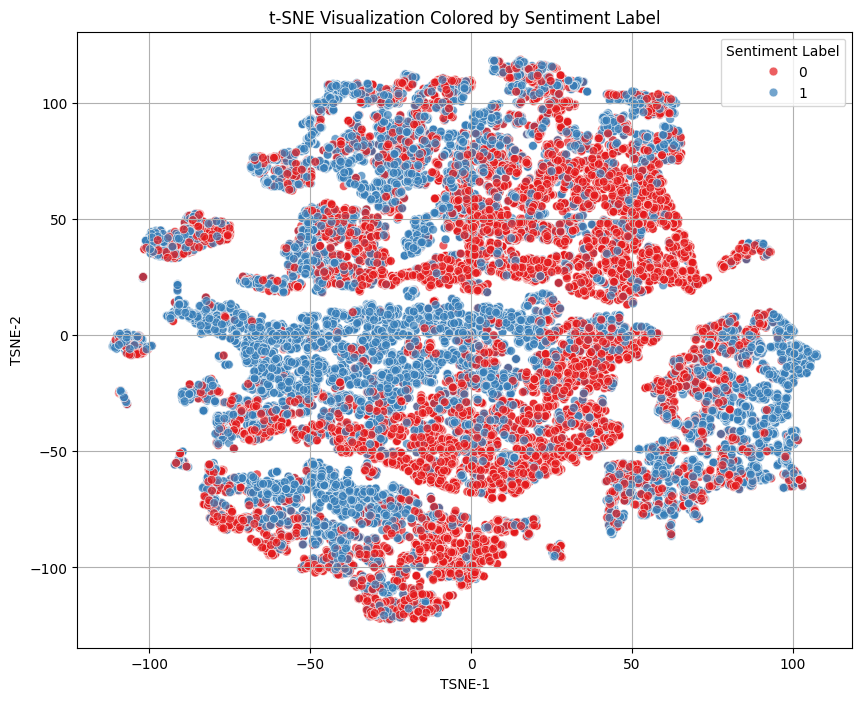

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(normalized_embeddings)
y_true = train_ds_reduced["label"]
plt.figure(figsize=(10, 8))
palette = sns.color_palette("Set1", n_colors=len(set(y_true)))  # distinct colors for each label
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_true, palette=palette, alpha=0.7, s=40)
plt.title('t-SNE Visualization Colored by Sentiment Label')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(title='Sentiment Label')
plt.grid(True)
plt.show()

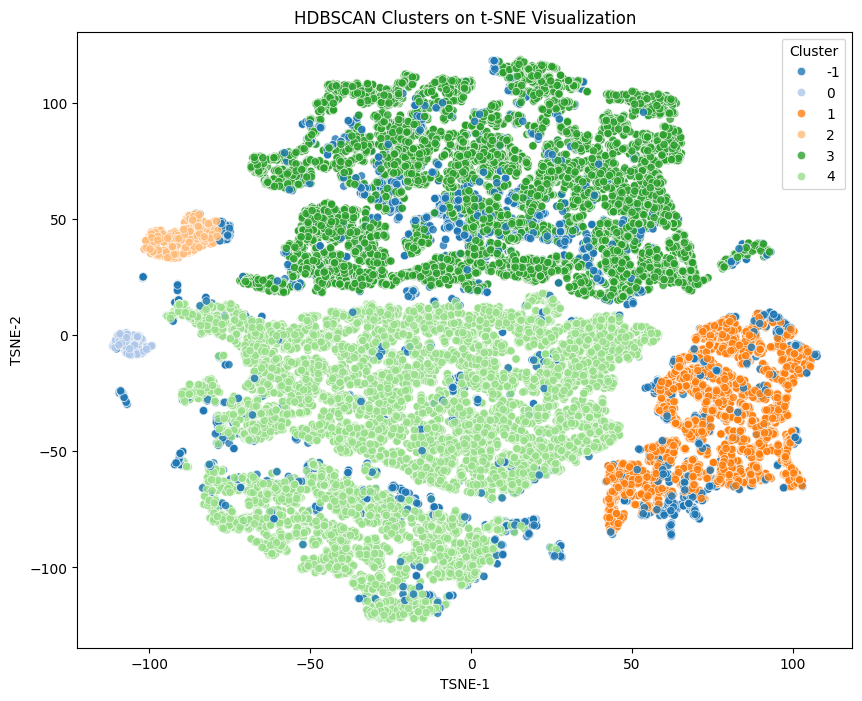

In [21]:
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# 1. Cluster on your original embeddings (high-dimensional space)
clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
labels = clusterer.fit_predict(normalized_embeddings)

# 2. Run t-SNE on the same original embeddings for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(normalized_embeddings)

# 3. Plot t-SNE results colored by HDBSCAN cluster labels
plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab20", n_colors=len(set(labels)))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette=palette, legend='full', alpha=0.8)

plt.title("HDBSCAN Clusters on t-SNE Visualization")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title='Cluster')
plt.show()
